# Nutrient analysis of global fisheries II

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import matplotlib as mp
import arviz as az
import pdb

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

In [3]:
def pairplot_divergence(trace, basevar, targetvar, ax=None, divergence=True, color='C3', divergence_color='C2'):
    #theta = trace.get_values(varname=basevar, combine=True)[:, 0]
    theta = trace.get_values(varname=basevar, combine=True)
    logtau = trace.get_values(varname=targetvar, combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel(basevar)
    ax.set_ylabel(targetvar)
    ax.set_title('scatter plot between log('+targetvar+') and '+basevar);
    return ax

# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace,basevar,targetvar,logscale=False):
    # plot the trace of log(tau)
    pm.traceplot({targetvar: trace.get_values(varname=targetvar, combine=False)});

    # plot the estimate for the mean of log(τ) cumulating mean
    if logscale:
        logtau = np.log(trace[targetvar])
    else:
        logtau = trace[targetvar]
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    #plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log('+targetvar+')')
    plt.title('MCMC estimation of log('+targetvar+')')
    plt.show()

    # display the total number and percentage of divergent
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size / len(trace) * 100
    print('Percentage of Divergent %.1f' % divperc)

    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space
    pairplot_divergence(trace,basevar,targetvar);

## Import data

In [4]:
# Nutritional data
ndata = pd.read_excel('Nutrient_data.xlsx')
# Traits data
tdata = pd.read_excel('Traits_all.xlsx')

In [5]:
# Subset ndata
#ndata = ndata.iloc[:100]

In [6]:
# Add traits information to nutritional dataframe
indx = match(ndata.Species_from_search.unique(),list(tdata.species_traits_all.values))
rindx = match(ndata.Species_from_search,list(ndata.Species_from_search.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]

ndata.head()

,ID_no,Species_from_search,Protein_Replicates,Protein_Value_perc,Protein_Variance,Zn_Replicates,Zn_Value,Zn_Variance,Ca_Replicates,Ca_Value,...,Genus_1,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,LMax,BodyShapeI,K,tm
0,A_3,Merluccius_merluccius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Merluccius,demersal,temperate,1075.0,4.40,pelagic,140.0,elongate,0.148,4.199469
1,A_4,Scomber_scombrus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
2,A_38,Scomber_scombrus,NaN,NaN,NaN,11,0.8090,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
3,A_39,Merluccius_gayi_gayi,NaN,NaN,NaN,11,0.1787,NaN,NaN,NaN,...,Merluccius,pelagic_oceanic,polar_deep,500.0,4.26,pelagic,87.0,fusiform,0.120,5.100000
4,A_40,Engraulis_encrasicolus,NaN,NaN,NaN,11,0.7041,NaN,NaN,NaN,...,Engraulis,pelagic_neritic,subtropical,400.0,3.12,pelagic,20.0,elongate,1.000,1.000000


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
ndata.head()

,ID_no,Species_from_search,Protein_Replicates,Protein_Value_perc,Protein_Variance,Zn_Replicates,Zn_Value,Zn_Variance,Ca_Replicates,Ca_Value,Ca_Variance,Fe_Replicates,Fe_Value,Fe_Variance,Se_Replicates,Se_Value,Se_Variance,P_Replicates,P_Value,P_Variance,Mg_Replicates,Mg_Value,Mg_Variance,VitA_Replicates,VitA_Value,VitA_Variance,VitB12_Replicates,VitB12_Value,VitB12_Variance,O3_Replicates,O3_Value,O3_Variance,Unnamed: 32,Form_Clean,Search,Year,GeographicLocation_Cleaned,Family,Prep,Protein_prep,Minerals_prep,Vitamin_prep,FA_prep,Protein_Sample_Weight,Zn_Sample_Weight,Ca_Sample_Weight,Fe_Sample_Weight,Se_Sample_Weight,P_Sample_Weight,Mg_Sample_Weight,VitA_Sample_Weight,VitB12_Sample_Weight,O3_Sample_Weight,Class,Order,Genus_1,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,LMax,BodyShapeI,K,tm
0,A_3,Merluccius_merluccius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,muscle,WOS,2014.0,Italy,Merlucciidae,wet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actinopterygii,Gadiformes,Merluccius,demersal,temperate,1075.0,4.40,pelagic,140.0,elongate,0.148,4.199469
1,A_4,Scomber_scombrus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,muscle,WOS,2014.0,Italy,Scombridae,wet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actinopterygii,Perciformes,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
2,A_38,Scomber_scombrus,NaN,NaN,NaN,11,0.8090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,22.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,muscle,WOS,2013.0,Spain,Scombridae,wet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actinopterygii,Perciformes,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
3,A_39,Merluccius_gayi_gayi,NaN,NaN,NaN,11,0.1787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,muscle,WOS,2013.0,Spain,Merlucciidae,wet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actinopterygii,Gadiformes,Merluccius,pelagic_oceanic,polar_deep,500.0,4.26,pelagic,87.0,fusiform,0.120,5.100000
4,A_40,Engraulis_encrasicolus,NaN,NaN,NaN,11,0.7041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,muscle,WOS,2013.0,Spain,Engraulidae,wet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actinopterygii,Clupeiformes,Engraulis,pelagic_neritic,subtropical,400.0,3.12,pelagic,20.0,elongate,1.000,1.000000


### Datasets

In [9]:
Nutrients = ['Protein', 'Zinc', 'Iron', 'Calcium', 'Omega-3', 'Vitamin_A', 'Selenium']
Nkeys = ['Protein_Value_perc', 'Zn_Value', 'Fe_Value', 'Ca_Value', 'O3_Value', 'VitA_Value', 'Se_Value']
nnutrients = len(Nutrients)

In [10]:
# Sample sizes for each nutrient
[sum(np.isnan(ndata[n].values)==False) for n in Nkeys]

[627, 196, 173, 170, 176, 69, 134]

## ======= Loop over nutrients ========= #

In [11]:
i = 0
nut = Nutrients[i]
nut

'Protein'

In [12]:

# Response
var = Nkeys[i]
Y_ = ndata[var].values


In [13]:
len(Y_)

932

In [14]:
# Units
#'Protein' - g/100g OK
#'Zinc' - mg/100g ---> multiply by 10
#'Iron' - mg/100g ---> multiply by 10
#'Calcium' - mg/100g OK
#'Omega-3': - g/100g ----> multiply by 10
#'Vitamin_A' - μg/100g OK
#'Selenium' - μg/100g OK


# Response
var = Nkeys[i]
Y_ = ndata[var].values

# NA Filter
indx = np.isfinite(Y_)
### ZEROS Filter
if nut in ['Selenium', 'Calcium']:
    indx = indx*(Y_>0)
    
### Protein beyond 60% Filter
if nut in ['Protein']:
    indx = indx*(Y_<60)
    
### Zinc beyond 11 Filter
#if nut in ['Zinc']:
#    indx = indx*(Y_<10)
    
### Omega-3 beyond 610 Filter
if nut in ['Omega-3']:
    indx = indx*(Y_<10)

# Remove non-useful data
Y_ = Y_[indx]

# Unit conversions for better models
if nut in ['Omega-3']:
    Y_ = Y_*10

    
# Log-scale
Ylog = np.log(Y_+1)

# Observation scale
Y = Y_
# Filter dataframe
tmpdata = ndata[indx]

# Index for orders
Order,Io = subindexall(tmpdata.Order.values, tmpdata['Species_from_search'].values)
nord = len(Order)

# Index for species
spxs = list(tmpdata['Species_from_search'].values)
sindx = np.array([spxs.index(s) for s in np.unique(spxs)])

# Species-level covariates
Habitat,Ih = subindexall(tmpdata['DemersPelag'].values, tmpdata['Species_from_search'].values)
nhabs = len(Habitat)
Climate,Ic = subindexall(tmpdata['EnvTemp'].values, tmpdata['Species_from_search'].values)
nclim = len(Climate)
MaxDepth = np.log(tmpdata['DepthRangeDeep'].values)[sindx]
TL = tmpdata['trophic_level'].values[sindx]
FeedPath, Ifp = indexall(tmpdata['Feeding_path'].values[sindx])
nfp = len(FeedPath)
LMax = np.log(tmpdata['LMax'].values)[sindx]
Body,Ib = subindexall(tmpdata['BodyShapeI'].values, tmpdata['Species_from_search'].values)
nbod = len(Body)
K = tmpdata['K'].values[sindx]
tm = np.log(tmpdata['tm'].values)[sindx]

# Nussiance parameters
Form,If = indexall(tmpdata['Form_Clean'].values)
nform = len(Form)
Prep,Ip = indexall(tmpdata['Prep'].values)
nprep = len(Prep)
Search,Is = indexall(tmpdata['Search'].values)
nsearch = len(Search)


In [15]:
FeedPath

['benthic', 'pelagic']

In [16]:
# Phylogentic distance matrix
pdata = pd.read_csv('mean_phy_dist.csv')
pdata.rename(columns={'Unnamed: 0':'spp'}, inplace=True)

# Average phylogentic relatedness value
meanp = np.mean(pdata,axis=1).mean()
# Store key for species locations in matrix
pkey = pdata.spp.values
# Drop species names column
pdata = pdata.drop('spp',axis=1)
# Add last row of average and turn into matrix
pdata = np.vstack([pdata.values,[meanp]*len(pdata.values[0])])
pdata = np.hstack((pdata, np.ones((pdata.shape[0], 1), dtype=pdata.dtype)*meanp))
# Set last diagonal value to -999
pdata[pdata.shape[0]-1,pdata.shape[0]-1] = -999
# Add missing species location
pkey = np.append(pkey,'Missing')

In [17]:
# Unique species in nutrients data
NutSpecies,Isp = indexall(tmpdata.Species_from_search.values)
nspp = len(NutSpecies)
# Grab phylogentic matrix index for species in data
pindx = match(NutSpecies,list(pkey))
# Assign missing index for missing species
pindx[pindx==None] = pdata.shape[0]-1
pindx = pindx.astype(int)

In [18]:
# Grab matching phylogentic matrix
Pmat = np.array([p[pindx] for p in pdata[pindx]])

In [19]:
# Replace missing values with average, plus some error
Pmat[Pmat==-999] = np.mean(Pmat[Pmat!=0][Pmat[Pmat!=0]!=-999])+np.random.normal(0,0.1,len(Pmat[Pmat==-999]))
# Scale correlations
Pmat = Pmat/max(Pmat.flatten())
# Constrain max correlation to 0.9
#Pmat[Pmat>0.9] = 0.9

In [20]:
Pmat[-1]

array([0.34820876, 0.53237343, 0.34312335, 0.34312334, 0.41383541,
       0.37343397, 0.37343397, 0.37343397, 0.37343397, 0.37343397,
       0.37343397, 0.37343397, 0.37343397, 0.57828505, 0.4138354 ,
       0.4138354 , 0.41383541, 0.41383541, 0.41383541, 0.41383541,
       0.36792077, 0.34820876, 0.34820876, 0.34820876, 0.34820876,
       0.34312335, 0.34820876, 0.34820876, 0.33964026, 0.34820876,
       0.34820876, 0.34820876, 0.34820876, 0.34312334, 0.34312335,
       0.34785278, 0.33964026, 0.33964026, 0.37343397, 0.37343397,
       0.48558758, 0.48558758, 0.37343397, 0.37343397, 0.37343397,
       0.37343397, 0.4138354 , 0.37343397, 0.48558758, 0.34820876,
       0.53237344, 0.34312335, 0.34312335, 0.53237344, 0.34820876,
       0.34312335, 0.34820876, 0.32294483, 0.33964026, 0.34820876,
       0.37343397, 0.37343397, 0.37343397, 0.37343397, 0.37343397,
       0.53237343, 0.33964026, 0.53237344, 0.230906  , 0.32294483,
       0.33964026, 0.34820876, 0.37343397, 0.33964026, 0.34820

In [21]:
# Diagonal
np.fill_diagonal(Pmat,0)

In [22]:
Pmat

array([[0.        , 0.53237343, 0.34820876, ..., 0.37343397, 0.31880566,
        0.34820876],
       [0.53237343, 0.        , 0.53237343, ..., 0.37343397, 0.53237343,
        0.53237343],
       [0.34820876, 0.53237343, 0.        , ..., 0.37343397, 0.34820876,
        0.34312335],
       ...,
       [0.37343397, 0.37343397, 0.37343397, ..., 0.        , 0.37343397,
        0.37343397],
       [0.31880566, 0.53237343, 0.34820876, ..., 0.37343397, 0.        ,
        0.34820876],
       [0.34820876, 0.53237343, 0.34312335, ..., 0.37343397, 0.34820876,
        0.        ]])

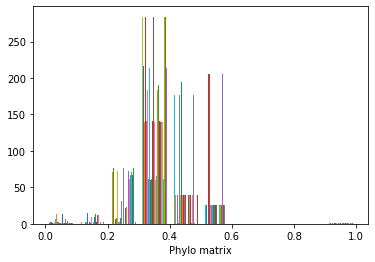

In [23]:
plt.hist(Pmat)
plt.xlabel('Phylo matrix');

In [24]:
Body

['short_deep', 'fusiform', 'elongate', 'flat']

In [25]:
Habitat

['reef_associated',
 'demersal',
 'benthopelagic',
 'pelagic_neritic',
 'pelagic_oceanic']

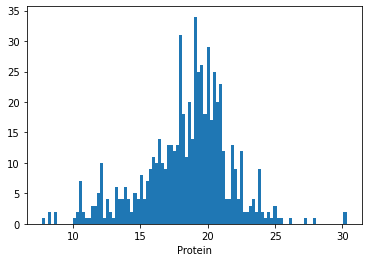

In [26]:
plt.hist(Y,bins=100)
plt.xlabel(nut);

In [27]:
len(Isp),max(Isp), Pmat.shape

(623, 284, (285, 285))

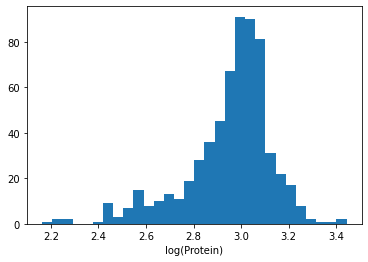

In [28]:
plt.hist(Ylog,bins=30)
plt.xlabel('log('+nut+')');

## Specify models

In [29]:
# Custom function 
class LinearMean(pm.gp.mean.Mean):
    def __init__(self, b0, b1, b2, b3, b4, b5, b6, b7, b8, b9):
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.b3 = b3
        self.b4 = b4
        self.b5 = b5
        self.b6 = b6
        self.b7 = b7
        self.b8 = b8
        self.b9 = b9

    def __call__(self, X):
        """Where do the covariates come from?"""
        return self.b0+self.b1+self.b2+self.b3*MaxDepth+self.b4*TL+self.b5+self.b6*LMax+self.b7+self.b8*K+self.b9*tm

In [30]:
with pm.Model() as Phylo_GP:
    ## Species level parameters
    # Intercept
    β0 = pm.Normal('Intercept', 0, 1)
    # Habitat type
    β1 = pm.Normal('Habitat', 0, 1, shape=nhabs)
    # Climate
    β2 = pm.Normal('Climate', 0, 1, shape=nclim)
    # Maximum Depth
    β3 = pm.Normal('MaxDepth', 0, 1)
    # Total Length
    β4 = pm.Normal('TL', 0, 1)
    # Pelagic/demersal
    β5 = pm.Normal('FeedPath', 0, 1, shape=nfp)
    # Maximum length
    β6 = pm.Normal('LMax', 0, 1)
    # Body form
    β7 = pm.Normal('Body', 0, 1, shape=nbod)
    # Growth parameter
    β8 = pm.Normal('K', 0, 1)
    # Age at maturity
    β9 = pm.Normal('tm', 0, 1)
    # Linear model for each species
    mu = LinearMean(β0,β1[Ih],β2[Ic],β3,β4,β5[Ifp],β6,β7[Ib],β8,β9)
    
    # half_normal(1, 0.25) is too strong
    etasq = pm.Exponential("etasq", .25)
    rhosq = pm.Normal("rhosq", 3, .25)
    #etasq = pm.Normal("etasq", 1.0, 0.25)
    
    # specify the covariance function:
    cov = etasq * pm.gp.cov.Exponential(input_dim=nspp, ls=rhosq)
    
    
    gp = pm.gp.Latent(mean_func=mu, cov_func=cov)
    # Species-level intercepts
    μ0 = gp.prior("μ0", X=Pmat)
    
    ## Observation level nussiance parameters
    # Form of sample
    μ1 = pm.Normal('Form', 0, 1, shape=nform)
    # Form of prepartion
    μ2 = pm.Normal('Prep', 0, 1, shape=nprep)
    # Database used
    μ3 = pm.Normal('Search', 0, 1, shape=nsearch)
    # Observation model
    μ_ = μ0[Isp]+μ1[If]+μ2[Ip]+μ3[Is]
    
    
    # Gamma model
    μ = tt.exp(μ_)
    α = pm.Gamma('α', 2, 2)
    Yi = pm.Gamma('Yi', alpha=α, beta=α/μ, observed=Ylog)

In [31]:
for RV in Phylo_GP.basic_RVs:
    print(RV.name, RV.logp(Phylo_GP.test_point))

Intercept -0.9189385332046727
Habitat -4.594692666023363
Climate -3.6757541328186907
MaxDepth -0.9189385332046727
TL -0.9189385332046727
FeedPath -1.8378770664093453
LMax -0.9189385332046727
Body -3.6757541328186907
K -0.9189385332046727
tm -0.9189385332046727
etasq_log__ -1.0596601002984287
rhosq 0.4673558279152179
μ0_rotated_ -261.89748196333244
Form -3.6757541328186907
Prep -2.756815599614018
Search -2.756815599614018
α_log__ -0.6137056388801094
Yi -1838.7103049017926


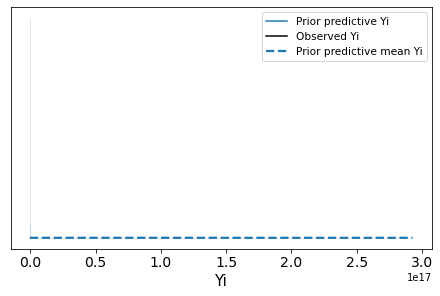

In [32]:
with Phylo_GP:
    prior = pm.sample_prior_predictive(700)
    Phylo_GP_priorp = az.from_pymc3(prior=prior)
az.plot_ppc(Phylo_GP_priorp, group="prior");

In [ ]:
# Sampling
with Phylo_GP:
    # Draw samples
    trace_Phylo_GP = pm.sample(1000)

/Users/aaronmacneil/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, Search, Prep, Form, μ0_rotated_, rhosq, etasq, tm, K, Body, LMax, FeedPath, TL, MaxDepth, Climate, Habitat, Intercept]


In [ ]:
posterior_predictive = pm.sample_posterior_predictive(trace, model=Phylo_GP)

In [ ]:
idata_checks = az.from_pymc3(
        model=Phylo_GP,
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive)

In [ ]:
def plot_ppc_loopit(idata, title):
    fig = plt.figure(figsize=(12,9))
    ax_ppc = fig.add_subplot(211)
    ax1 = fig.add_subplot(223); ax2 = fig.add_subplot(224)
    az.plot_ppc(idata, ax=ax_ppc);
    for ax, ecdf in zip([ax1, ax2], (False, True)):
        az.plot_loo_pit(idata, y="Yi", ecdf=ecdf, ax=ax);
    ax_ppc.set_title(title)
    ax_ppc.set_xlabel("")
    return np.array([ax_ppc, ax1, ax2])

In [ ]:
plot_ppc_loopit(idata_checks,nut+'_checks')
plt.savefig('PPC_'+nut+'.jpg',dpi=300);